In [0]:
import numpy as np
import scipy.special as ss
import matplotlib.pyplot as plt
from matplotlib import animation, rc

## Problem 1 Part A

Write a program to solve the 1D diffusion equation, using the Euler method for the time derivative, and both a three-point and five-point stencil to approximate the second-order spatial derivative. Assume that the initial condition for the probability distribution is $P(x,t=0)\propto e^{-(x-5)^2}$, where $0\leq x\leq 10$ and the system has periodic boundary conditions. You will likely find it easiest to encode the derivative operator as a matrix, as was done in the last assignment. Make a movie to show the evolution as a function of time, for time at least up to 10 in rescaled units. Note that the diffusion constant $D$ depends on both the spatial and temporal mesh. How does the behaviour compare with the evolution of the random walker / Markov chain?

### 3 Point Stencil

Recall from the previous assignment that the three point stencil (when $t=0$) can be approximated by the following function:

$$
P(x,t=0)=\frac{P(x+a)+P(x-a)}{2}
$$

Where a is the lattice spacing. For this problem we will be operating on the interval $0 \leq x \leq 10$, where our initial array is defined by the following:

$$
P(x,t=0) \propto e^{-(x-5)^2}
$$

For all defined values between 0 and 10. However, before we proceeed we must account for the proportionality. We can do this (i.e make the above expression an equality) by determining what the normalization constant is. We can do this by recalling the general description of the normal distribution:

$$
f(x|\mu,\sigma^2) = \frac{1}{\sqrt{2 \pi \sigma^2}}e^{-\frac{(x-\mu)^2}{2\sigma^2}}
$$

Which indicates that our value for $\sigma$ is given by the following:

$$
\sigma = \frac{1}{\sqrt{2}}
$$

Which means that our normalization coefficient $Z$ is given as follows:

$$
Z = \frac{1}{\sqrt{\pi}}
$$

Which means our initial array is given by:

$$
P(x,t=0) = \frac{1}{\sqrt{\pi}}e^{-(x-5)^2}
$$

In [0]:
def init_interval1(N):
  """
  This function initializes an array given by P(x,t=0) for problem 1.
  """
  x = np.linspace(0, 10, N, endpoint = True)
  f = []
  for val in x:
    f.append(np.exp(-(val - 5)**2))
  return x, np.array(f) / np.sqrt(np.pi)

And now, allow us to define a function that will define the coefficient matrix. The reason we wish to do this is that for us to determine the RHS of the diffusion equation we must solve:

$$
D\frac{\partial^2}{\partial x^2}p(x,t)
$$

Where, if we recall from the previous assignment, we can define everything as follows:

$$
D \cdot M \cdot p(x,t)
$$

The coefficient matrix is generated by:

In [0]:
def gen_3ptmatrix(N):
  """
  This function generates a matrix according to the 3-point stencil,
  with periodic boundary conditions.
  """
  matrix = []
  row = np.zeros(N)
  row[0], row[1], row[-1] = -2, 1, 1
  for i in range(N):
    matrix.append(row)
    row = np.roll(row, 1)
  return matrix

As always, allow us to test our code to make sure everything is working as expected:

In [7]:
#Testing init_interval1 and gen3pt_matrix

x, f = init_interval1(5)
M = gen_3ptmatrix(10)
#print(x)
#print(f)
print(np.matrix(M))

[[-2.  1.  0.  0.  0.  0.  0.  0.  0.  1.]
 [ 1. -2.  1.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  1. -2.  1.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  1. -2.  1.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  1. -2.  1.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  1. -2.  1.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  1. -2.  1.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  1. -2.  1.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  1. -2.  1.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.  1. -2.]]


The RHS of Euler's equation, which states that:

$$
\frac{\partial}{\partial t}f(t)=g(t)
$$

which becomes

$$
f(t_{n+1})=f(t_n)+hg(t_n)
$$

and where $g(t)$ is defined by the following:

$$
g(t) = D\frac{\partial^2}{\partial x^2}p(x,t)
$$

Where $D=a^2/2h$ and:

$$
\frac{\partial^2}{\partial x^2} = \frac{M}{a^2}
$$

Which leaves us with the following expression:

$$
g(t) = \frac{1}{2h}M \cdot p(x,t)
$$

Where h is our temporal spacing. As such, we must now define a function to compute g(t):

In [0]:
def g_t3(M, h, f, complex = False):
  """
  This function performs the operation of g(t) for the 3-point stencil.
  """
  M_P = np.matmul(M, f)
  if complex == True:
    return (1j/2)*M_P
  else:
    return (1/(2*h))*M_P

In [0]:
#Testing g_t3
N = 100
h = 0.01 
x, f = init_interval1(N)
M = gen_3ptmatrix(N)
g = g_t3(M, h, f)
#print(g)

Now that we have derived an expression and function for $g(t)$ we can make use of Euler's method, which again states that:

$$
f(t_{n+1}) = f(t_n) + hg(t_n)
$$

Where $g(t_n)$ is the second derivative of $f(t_n)$.

In [0]:
def Eulers_meth(h, f, g):
  """
  This function performs a singular Eulers method.
  """
  E = []
  f, g = np.array(f), np.array(g)
  return f + h*g

In [0]:
#Testing Eulers_meth
E = Eulers_meth(h, f, g_t3(M, h, f))
#print(E)

Now that we have tested all of our functions and defined everythin that is required, allow us to determine a solution:

In [0]:
#Solve the 1D Diffusion Equation using 3-Point Stencil

%%capture 
fig = plt.figure()
imgs1 = []

N = 100
h = 0.01 #Temporal spacing
tol = 1e-6
x, f = init_interval1(N)
M = gen_3ptmatrix(N)
iter = 0

f_0 = f.copy()

count = 0
while count != len(f):
  if (iter % 100 == 0) or (iter < 25):
    img = plt.plot(x, f, color = 'black')
    imgs1.append(img)
  
  f1 = Eulers_meth(h, f, g_t3(M, h, f))
  iter += 1

  count = 0
  for a_i, b_i in zip(f, f1):
    if abs(a_i - b_i) < tol:
      count += 1

  f = f1.copy()

ani1 = animation.ArtistAnimation(fig, imgs1)
ani1.save('Animation1.mp4')
rc('animation', html='html5')

Plotting everything yields:

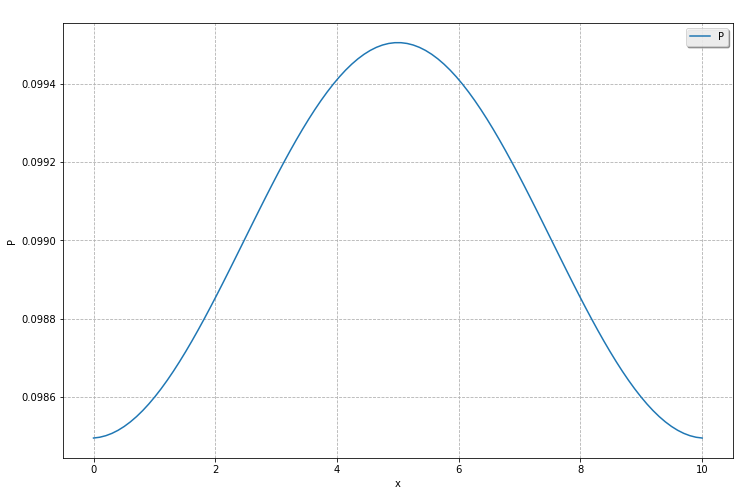

In [0]:
#Plotting Labels
plt.figure(figsize=(12,8))
plt.xlabel('x')
plt.ylabel('P')
plt.title(' ')
plt.grid(linestyle='dashed')

#Plot the Function
#plt.plot(x, f_0, label='$f_0$')
plt.plot(x, f, label='P')

#Legend Settings
legend = plt.legend(loc = 1, shadow = 'true')
frame = legend.get_frame()
frame.set_alpha(0.8)

Where our animation is:

In [0]:
print('It took', iter, 'iterations to generate P(x,t)')
ani1

It took 2974 iterations to generate P(x,t)


### 5 Point Stencil

In this section will perform the exact same operation, however, we will re-define our coefficeint matrix for the 5-point stencil. The 5-point stencil is given by
$$
P(x,t=0)=\frac{-P(x+2a)+16P(x+a)-30P(x)+16P(x-a)-P(x-2a)}{12a^2}
$$

In [0]:
def gen_5ptmatrix(N):
  """
  This function generates a matrix according to the 5-point stencil,
  with periodic boundary conditions.
  """
  matrix = []
  row = np.zeros(N)
  row[0], row[1], row[2], row[-1], row[-2] = -30, 16, -1, 16, -1
  for i in range(N):
    matrix.append(row)
    row = np.roll(row, 1)
  return matrix

In [0]:
#Testing gen_5ptmatrix
M = gen_5ptmatrix(6)
#print(np.matrix(M))

Now, recall that we must once again
calculate the RHS of our diffusion equation, which is also known as $g(t)$:

$$
g(t) = D\frac{\partial^2}{\partial x^2}p(x,t)
$$

However, this time we have a different coefficient in front of our matrix. This indicates that:

$$
\frac{\partial^2}{\partial x^2} = \frac{M}{12a^2}
$$

And recall that $D=a^2/2h$, as such, the RHS of our diffusion equation will be equivalent to the following:

$$
g(t) = \frac{1}{24h}M \cdot p(x,t)
$$

Where h is again our temporal spacing.

In [0]:
def g_t5(M, h, f, complex = False):
  """
  This function performs the operation of g(t) for the 5-point stencil.
  """
  M_P = np.matmul(M, f)
  if complex == True:
    return (1j/24)*M_P
  else:
    return (1/(24*h))*M_P

In [0]:
#Testing g_t5
N = 100
h = 0.01 
x, f = init_interval1(N)
M = gen_5ptmatrix(N)
g = g_t5(M, h, f)
#print(g)

Now, if we are to run our code without the process of smoothing (much like in our last assignmet) our solution blows up to infinity. As such, allow us to define a smoothing function:

In [0]:
def smooth(arr):
  """
  This function will be used to smooth our array as we perform Eulers method
  in order to prevent the function from blowing up.
  """
  smoothed_arr = []
  for i in range(len(arr)):
    if (i == 0):
      smoothed_arr.append((arr[-1]+arr[i]+arr[i+1])/3)
    elif (i == (len(arr)-1)):
      smoothed_arr.append((arr[i-1]+arr[i]+arr[0])/3)
    else:
      smoothed_arr.append((arr[i-1]+arr[i]+arr[i+1])/3)
  return np.array(smoothed_arr)

Again, running everything to produce our results:

In [0]:
#Solve the 1D Diffusion Equation using 5-Point Stencil

%%capture 
fig = plt.figure()
imgs2 = []

N = 100
h = 0.01
tol = 1e-6
x, f = init_interval1(N)
M = gen_5ptmatrix(N)
iter = 0

f_0 = f.copy()

count = 0
while count != len(f):
#while iter < 5000:
  if (iter % 100 == 0) or (iter < 25):
    img = plt.plot(x, f, color = 'black')
    imgs2.append(img)

  if (iter % 2 == 0):
    f = smooth(f)  

  f1 = Eulers_meth(h, f, g_t5(M, h, f))
  iter += 1

  count = 0
  for a_i, b_i in zip(f, f1):
    if abs(a_i - b_i) < tol:
      count += 1

  f = f1.copy()

ani2 = animation.ArtistAnimation(fig, imgs2)
ani2.save('Animation2.mp4')
rc('animation', html='html5')

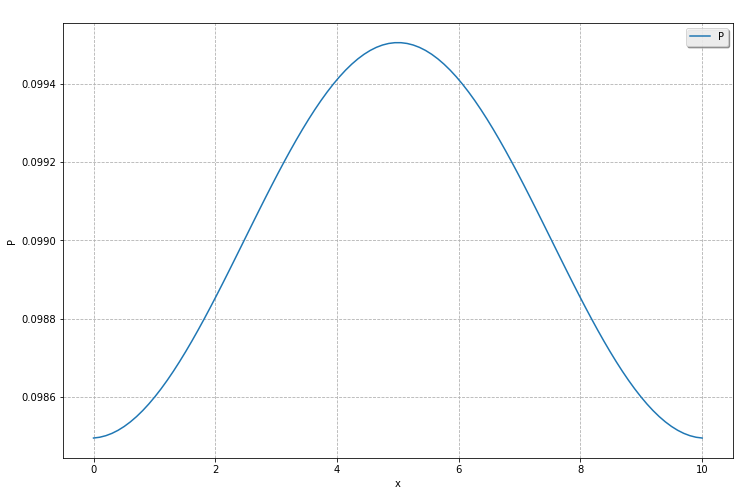

In [0]:
#Plotting Labels
plt.figure(figsize=(12,8))
plt.xlabel('x')
plt.ylabel('P')
plt.title(' ')
plt.grid(linestyle='dashed')

#Plot the Function
#plt.plot(x, f_0, label='$f_0$')
plt.plot(x, f, label='P')

#Legend Settings
legend = plt.legend(loc = 1, shadow = 'true')
frame = legend.get_frame()
frame.set_alpha(0.8)

In [0]:
print('It took', iter, 'iterations to generate P(x,t)')
ani2

It took 2230 iterations to generate P(x,t)


## Problem 1 Part B

Does the choice of the temporal mesh (given some spatial mesh) affect the stability of the propagation? If so, how?

In this problem we will explore how varying the temporal mesh affects the stability of the systems propogation forward. To start allow us to determine the final solution for a variety of mesh sizes to see how it affects our data set.

### 3 Point Stencil

We will start by generating data for a variety of temporal meshes:

In [0]:
N = 100
tol = 1e-6
M = gen_3ptmatrix(N)

master_list = []
iter_list = []
name_list = []
h_list = [1, 1e-1, 1e-2, 1e-3]
for h in h_list:
  x, f = init_interval1(N)
  iter = 0
  count = 0
  while count != len(f):

    if (iter % 2 == 0):
      f = smooth(f)  

    f1 = Eulers_meth(h, f, g_t3(M, h, f))
    iter += 1

    count = 0
    for a_i, b_i in zip(f, f1):
      if abs(a_i - b_i) < tol:
        count += 1

    f = f1.copy()

  master_list.append(f)
  iter_list.append(iter)
  name_list.append('h = ' + str(h))

And plotting these results yields:

Temporal Mesh of h = 1 required 2231 iterations to determine the function.
Temporal Mesh of h = 0.1 required 2231 iterations to determine the function.
Temporal Mesh of h = 0.01 required 2231 iterations to determine the function.
Temporal Mesh of h = 0.001 required 2231 iterations to determine the function.


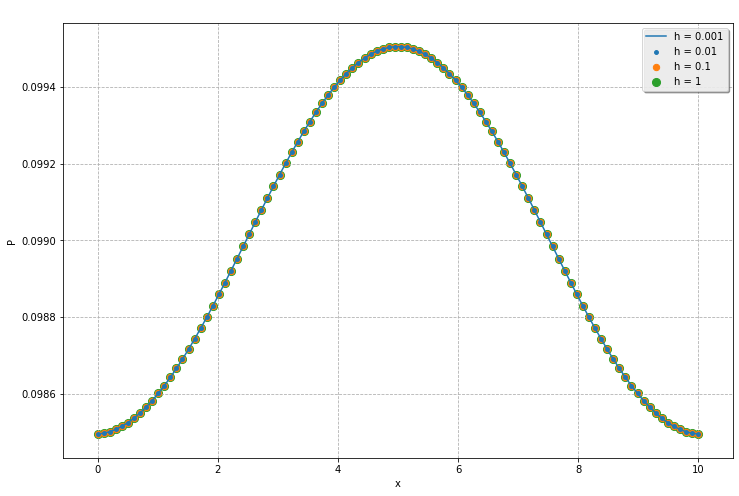

In [0]:
for i in range(len(master_list)):
  print('Temporal Mesh of h =', h_list[i], 'required', iter_list[i], 
        'iterations to determine the function.')

#Plotting Labels
plt.figure(figsize=(12,8))
plt.xlabel('x')
plt.ylabel('P')
plt.title(' ')
plt.grid(linestyle='dashed')

#Plot the Function
#plt.plot(x, f_0, label='$f_0$')
plt.plot(x, master_list[3], label=name_list[3])
plt.scatter(x, master_list[2], label=name_list[2], s = 15, zorder=3)
plt.scatter(x, master_list[1], label=name_list[1], s = 40, zorder=2)
plt.scatter(x, master_list[0], label=name_list[0], s = 65, zorder=1)

#Legend Settings
legend = plt.legend(loc = 1, shadow = 'true')
frame = legend.get_frame()
frame.set_alpha(0.8)

Allow us to examine the 5-point stencil data before making any conclusions.

### 5 Point Stencil

Again, generating data for plotting:

In [0]:
N = 100
tol = 1e-6
M = gen_5ptmatrix(N)

master_list = []
iter_list = []
name_list = []
h_list = [1, 1e-1, 1e-2, 1e-3]
for h in h_list:
  x, f = init_interval1(N)
  iter = 0
  count = 0
  while count != len(f):

    if (iter % 2 == 0):
      f = smooth(f)  

    f1 = Eulers_meth(h, f, g_t5(M, h, f))
    iter += 1

    count = 0
    for a_i, b_i in zip(f, f1):
      if abs(a_i - b_i) < tol:
        count += 1

    f = f1.copy()

  master_list.append(f)
  iter_list.append(iter)
  name_list.append('h = ' + str(h))

And plotting:

Temporal Mesh of h = 1 required 2230 iterations to determine the function.
Temporal Mesh of h = 0.1 required 2230 iterations to determine the function.
Temporal Mesh of h = 0.01 required 2230 iterations to determine the function.
Temporal Mesh of h = 0.001 required 2230 iterations to determine the function.


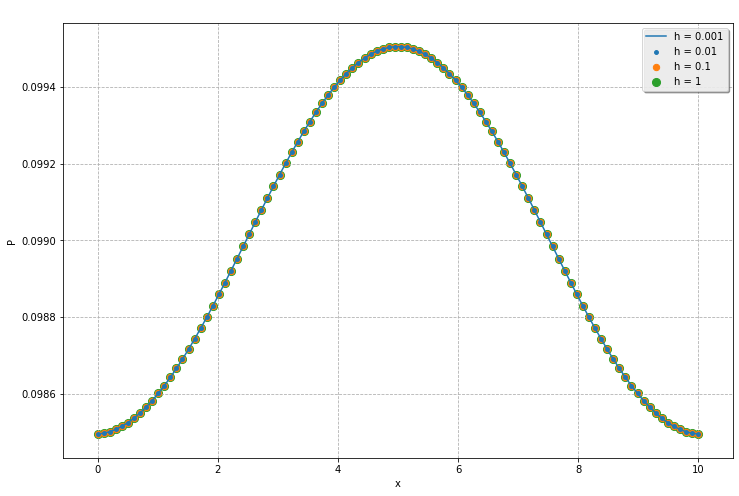

In [0]:
for i in range(len(master_list)):
  print('Temporal Mesh of h =', h_list[i], 'required', iter_list[i], 
        'iterations to determine the function.')

#Plotting Labels
plt.figure(figsize=(12,8))
plt.xlabel('x')
plt.ylabel('P')
plt.title(' ')
plt.grid(linestyle='dashed')

#Plot the Function
#plt.plot(x, f_0, label='$f_0$')
plt.plot(x, master_list[3], label=name_list[3])
plt.scatter(x, master_list[2], label=name_list[2], s = 15, zorder=3)
plt.scatter(x, master_list[1], label=name_list[1], s = 40, zorder=2)
plt.scatter(x, master_list[0], label=name_list[0], s = 65, zorder=1)

#Legend Settings
legend = plt.legend(loc = 1, shadow = 'true')
frame = legend.get_frame()
frame.set_alpha(0.8)

We can see that the number of iterations required to determine the function did not vary significantly with the change of the temporal mesh. From the plots we can also see that the points in the interval are determined to be the same. Therefore we conclude changing the temporal mesh does not effect the ability of the algorithm to determine the function from the differential equation

We confirm this by analyzing analytically what happens with the temporal mesh in our algorithm. The reason that these plots are the exact same given a variation in temporal mesh is because in our expression for D, our prefactor for the diffusion equation is given by:

$$
D = \frac{1}{2h}
$$

Where $h$ is the temporal mesh spacing. Whenever we take a step of $h$ in our Euler function we are are ALSO multiplying the function by $h$, i.e recall that:

$$
f(t_{n+1}) = f(t_n) + hg(t_n)
$$

Thereby, every time we step our D is equivalent to:

$$
D= \frac{1}{2}
$$

Thereby, whenever we take a step, no matter the temporal spacing, it will never change! That is why our plots are the exact same.

## Problem 2 Part A

Repeat Problem 1, but now for Schrodinger's equation. The initial condition is now
$\psi(x,t=0)\propto e^{-(x-5)^2/2}$. Please propagate the solution up to a time of at least 5 in rescaled units. Check that the probability is conserved throughout the propagation. How does the behavior compare to that of the diffusion equation? Why do you think it behaves like this?

**Note**: The reason we see interferance is because we add an imaginary componenent to the schrodinger wave equation - otherwise, it is exactly the same as the diffusion equation. But this additional i term is important - because it implies that we can have a phase shift. The interesting this is that phase is what allows wavefunctions to intefere. Thereby, this additional complex term will allow for wave interference - which is why we see the crazy patterns in his solutions.

Notice, we are required to calculate the probability of our wavefunctions:

$$
Probability = |\Psi|^2
$$

For this problem we will be operating on the interval $0 \leq x \leq 10$, where our initial array is defined by the following:

$$
\psi(x,t=0)\propto e^{-(x-5)^2/2}
$$

Which we can make an equivalance with some undetermined constant:

$$
\psi(x,t=0)= \frac{1}{Z} e^{-(x-5)^2/2}
$$

where our interval is $0 \leq x \leq 10$.

Recall that we must normalize the PROBABILITY distribution of the wave function. That being:

$$
|\psi(x,t=0)|^2 = \frac{1}{Z^2} e^{-(x-5)^2}
$$


Recall the general Gaussian distribution:

$$
f(x|\mu,\sigma^2) = \frac{1}{\sqrt{2 \pi \sigma^2}}e^{-\frac{(x-\mu)^2}{2\sigma^2}}
$$

This indicates that $\sigma = \sqrt{2}$ for our distribution, and thereby:

$$
Z = \left( \frac{1}{\pi}\right)^{0.25}
$$

Which results in the following equation:

$$
\psi(x,t=0) = \left(\frac{1}{\pi}\right)^{0.25} e^{-(x-5)^2/2}
$$

In [0]:
def init_interval2(N):
  """
  This function initializes an array given by Psi(x,t=0) for problem 2.
  """
  x = np.linspace(0, 10, N, endpoint = True)
  f = []
  for val in x:
    f.append(((np.pi)**(-0.25))*np.exp((-1/2)*(val - 5)**2))
  return x, np.array(f)

In the Schrodinger equation, we are concerned with the probabilities associated with our wavefunction which is given by $|\psi(x,t=0)|^2$. So let us see if we have properly normalized our array.

In [0]:
#Testing init_interval2

x, f = init_interval2(500)
#print(x)
#print(f)
f2 = f**2
#print(f2)
total_p = np.trapz(f2, x)
print(total_p) #Check to see if our probability distribution is properly normalized

0.9999999999984573


Now, as before we must start by determining the RHS of our Schrodinger equation, which is given by the following:

$$
i\hbar\frac{\partial}{\partial t}\psi(x,t)=\left[-\frac{\hbar^2}{2m}\frac{\partial^2}{\partial x^2}+V(x)\right]\psi(x,t)
$$

Now, for the purposes of this assignment we will set $V(x) = 0$ which leaves us with the following expression:

$$
i\hbar\frac{\partial}{\partial t}\psi(x,t)=-\frac{\hbar^2}{2m}\frac{\partial^2}{\partial x^2}\psi(x,t)
$$

Where for the purposes of this assignment, we can generalize $\hbar$ and $m$ as "generalized coordinates", thereby:

$$
\hbar = 1 \: and \: m =1
$$

Which finally yields:

$$
i\frac{\partial}{\partial t}\psi(x,t)=-\frac{1}{2}\frac{\partial^2}{\partial x^2}\psi(x,t)
$$

Where we can multiply both sides by $i$ to yield:

$$
\frac{\partial}{\partial t}\psi(x,t)=\frac{i}{2}\frac{\partial^2}{\partial x^2}\psi(x,t)
$$

As such, we can utilize our 3-point and 5-point stencil functions from the previous problem in order to solve our Schrodinger equation. Let us generate our data.

In [0]:
#Solve the Shrodinger Equation using 3-Point Stencil

%%capture 
fig = plt.figure()
imgs3 = []

N = 500
h = 1 #Temporal spacing
tol = 1e-6
x, f = init_interval2(N)
M = gen_3ptmatrix(N)
iter = 0

f_0 = f.copy()

count = 0
#while count != len(f):
while iter < 100:
  if (iter % 100 == 0) or (iter < 25):
    img = plt.plot(x, f, color = 'black')
    imgs3.append(img)

  if iter % 1 == 0:
    f = smooth(f)  

  f1 = Eulers_meth(h, f, g_t3(M, h, f, complex = True))
  iter += 1

  count = 0
  for a_i, b_i in zip(f, f1):
    if abs(a_i - b_i) < tol:
      count += 1

  f = f1.copy()

f = np.array(f)
ani3 = animation.ArtistAnimation(fig, imgs3)
ani3.save('Animation3.mp4')
rc('animation', html='html5')

And plotting:

/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


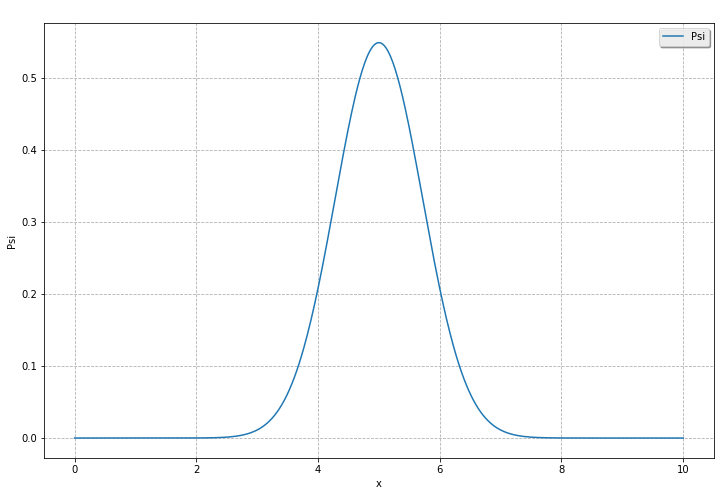

In [0]:
#Plotting Labels
plt.figure(figsize=(12,8))
plt.xlabel('x')
plt.ylabel('Psi')
plt.title(' ')
plt.grid(linestyle='dashed')

#Plot the Function
#plt.plot(x, f_0, label='$f_0$')
plt.plot(x, f**2, label='Psi')

#Legend Settings
legend = plt.legend(loc = 1, shadow = 'true')
frame = legend.get_frame()
frame.set_alpha(0.8)

With animation:

In [0]:
print('It took', iter, 'iterations to generate Psi(x,t)')
print('The total probability of the probability distribution of the final iteration is', abs(np.trapz(f**2, x)))
ani3

It took 100 iterations to generate Psi(x,t)
The total probability of the probability distribution of the final iteration is 0.986501305026786


### 5 Point Stencil

Again, allow us to perform the same operations, but now, for the 5-point stencil:

In [0]:
#Solve the Schrodinger Equation using 5-Point Stencil

%%capture 
fig = plt.figure()
imgs4 = []

N = 100
h = 0.01
tol = 1e-6
x, f = init_interval2(N)
M = gen_5ptmatrix(N)
iter = 0

f_0 = f.copy()

count = 0
#while count != len(f):
while iter < 100:
  if (iter % 100 == 0) or (iter < 25):
    img = plt.plot(x, f, color = 'black')
    imgs4.append(img)

  if (iter % 1 == 0):
    f = smooth(f)  

  f1 = Eulers_meth(h, f, g_t5(M, h, f, complex = True))
  iter += 1

  count = 0
  for a_i, b_i in zip(f, f1):
    if abs(a_i - b_i) < tol:
      count += 1

  f = f1.copy()

ani4 = animation.ArtistAnimation(fig, imgs4)
ani4.save('Animation4.mp4')
rc('animation', html='html5')

Plotting again:

/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


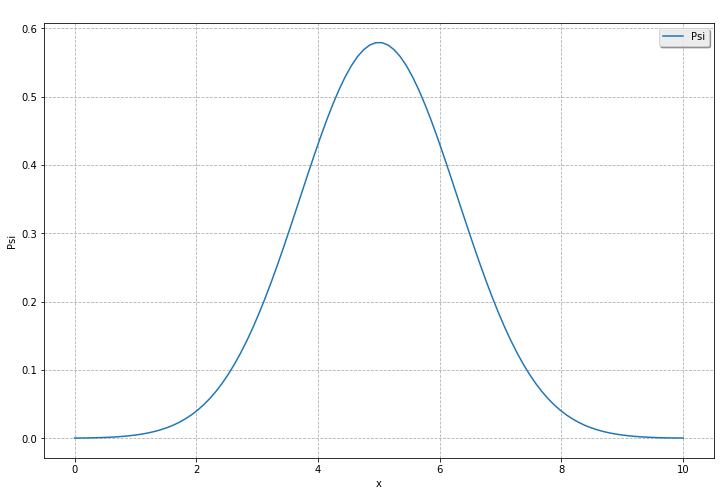

In [0]:
#Plotting Labels
plt.figure(figsize=(12,8))
plt.xlabel('x')
plt.ylabel('Psi')
plt.title(' ')
plt.grid(linestyle='dashed')

#Plot the Function
#plt.plot(x, f_0, label='$f_0$')
plt.plot(x, f, label='Psi')

#Legend Settings
legend = plt.legend(loc = 1, shadow = 'true')
frame = legend.get_frame()
frame.set_alpha(0.8)

With animation:

In [0]:
print('It took', iter, 'iterations to generate Psi(x,t)')
print('The total probability of the probability distribution of the final iteration is', abs(np.trapz(f**2, x)))
ani4

It took 100 iterations to generate Psi(x,t)
The total probability of the probability distribution of the final iteration is 0.7713448129427082


## Problem 2 Part B

How small a timestep is needed to ensure that the propagation is stable over this time interval? How does the value compare with that found in Problem 1?

### 3 Point Stencil

In [0]:
N = 100
tol = 1e-6
M = gen_3ptmatrix(N)

master_list = []
iter_list = []
name_list = []
h_list = [5, 1, 1e-1, 1e-2]
for h in h_list:
  x, f = init_interval2(N)
  iter = 0
  count = 0
  #while count != len(f):
  while iter < 100:
    if (iter % 1 == 0):
      f = smooth(f)  

    f1 = Eulers_meth(h, f, g_t3(M, h, f, complex = True))
    iter += 1

    count = 0
    for a_i, b_i in zip(f, f1):
      if abs(a_i - b_i) < tol:
        count += 1

    f = f1.copy()

  master_list.append(f)
  iter_list.append(iter)
  name_list.append('h = ' + str(h))

Temporal Mesh of h = 5 required 100 iterations to determine the function.
Temporal Mesh of h = 1 required 100 iterations to determine the function.
Temporal Mesh of h = 0.1 required 100 iterations to determine the function.
Temporal Mesh of h = 0.01 required 100 iterations to determine the function.


/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:138: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order, subok=True)


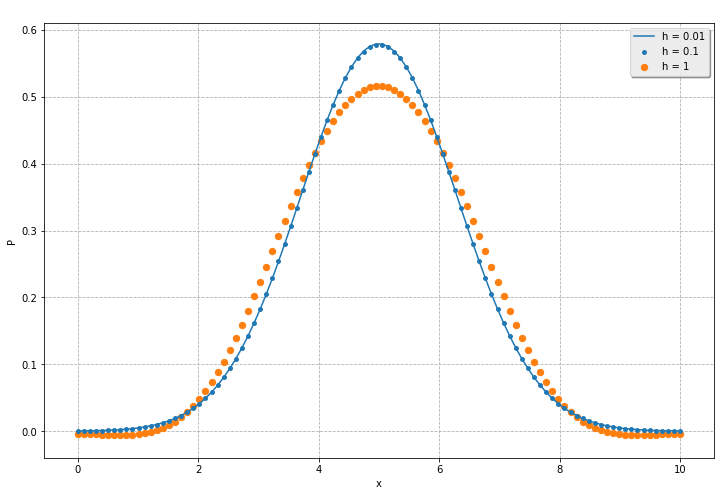

In [0]:
for i in range(len(master_list)):
  print('Temporal Mesh of h =', h_list[i], 'required', iter_list[i], 
        'iterations to determine the function.')

#Plotting Labels
plt.figure(figsize=(12,8))
plt.xlabel('x')
plt.ylabel('P')
plt.title(' ')
plt.grid(linestyle='dashed')

#Plot the Function
#plt.plot(x, f_0, label='$f_0$')
plt.plot(x, master_list[3], label=name_list[3])
plt.scatter(x, master_list[2], label=name_list[2], s = 15, zorder=3)
plt.scatter(x, master_list[1], label=name_list[1], s = 40, zorder=2)
#plt.scatter(x, master_list[0], label=name_list[0], s = 65, zorder=1)

#Legend Settings
legend = plt.legend(loc = 1, shadow = 'true')
frame = legend.get_frame()
frame.set_alpha(0.8)

### 5 Point Stencil

In [0]:
N = 100
tol = 1e-6
M = gen_5ptmatrix(N)

master_list = []
iter_list = []
name_list = []
h_list = [5, 1, 1e-1, 1e-2]
for h in h_list:
  x, f = init_interval2(N)
  iter = 0
  count = 0
  #while count != len(f):
  while iter < 100:
    if (iter % 1 == 0):
      f = smooth(f)  

    f1 = Eulers_meth(h, f, g_t5(M, h, f, complex = True))
    iter += 1

    count = 0
    for a_i, b_i in zip(f, f1):
      if abs(a_i - b_i) < tol:
        count += 1

    f = f1.copy()

  master_list.append(f)
  iter_list.append(iter)
  name_list.append('h = ' + str(h))

Temporal Mesh of h = 5 required 100 iterations to determine the function.
Temporal Mesh of h = 1 required 100 iterations to determine the function.
Temporal Mesh of h = 0.1 required 100 iterations to determine the function.
Temporal Mesh of h = 0.01 required 100 iterations to determine the function.


/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:138: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order, subok=True)


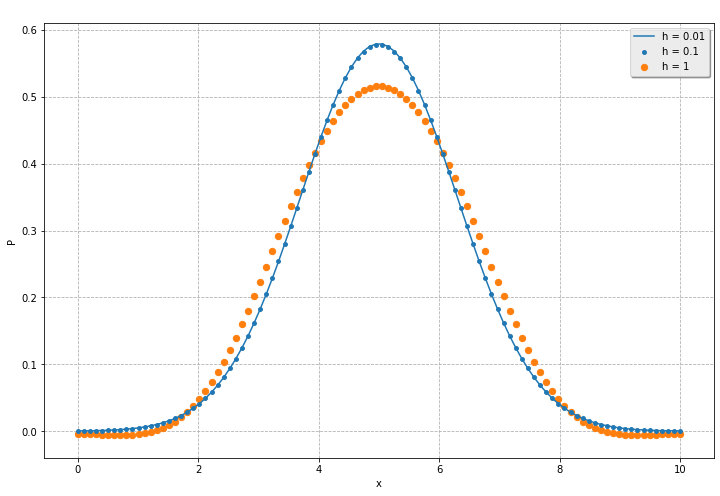

In [0]:
for i in range(len(master_list)):
  print('Temporal Mesh of h =', h_list[i], 'required', iter_list[i], 
        'iterations to determine the function.')

#Plotting Labels
plt.figure(figsize=(12,8))
plt.xlabel('x')
plt.ylabel('P')
plt.title(' ')
plt.grid(linestyle='dashed')

#Plot the Function
#plt.plot(x, f_0, label='$f_0$')
plt.plot(x, master_list[3], label=name_list[3])
plt.scatter(x, master_list[2], label=name_list[2], s = 15, zorder=3)
plt.scatter(x, master_list[1], label=name_list[1], s = 40, zorder=2)
#plt.scatter(x, master_list[0], label=name_list[0], s = 65, zorder=1)

#Legend Settings
legend = plt.legend(loc = 1, shadow = 'true')
frame = legend.get_frame()
frame.set_alpha(0.8)

## Problem 3

Again solve problems 1 and 2 above, but now use fourth-order Runge-Kutta instead of Euler's method. In this case, instead of
$$f(t_{n+1})=f(t_n)+hg(t_n),$$
the propagation over the full timestep $h$ makes use of several intermediate steps as follows. If we define the action of the spatial second derivative on the state at $t_n$ as $M\cdot f(t_n)$, then one fourth-order RK step requires defining
\begin{eqnarray}
k_1 &=& M\cdot f(t_n)\\
k_2 &=& M\cdot\left[f(t_n)+0.5k_1)\right]\\
k_3 &=& M\cdot\left[f(t_n)+0.5k_2)\right]\\
k_4 &=& M\cdot\left[f(t_n)+k_3\right],
\end{eqnarray}
so that the solution at the next time step is then
$$f(t_{n+1}) = f(t_n) + \frac{h}{6}(k_1 + 2k_2 + 2k_3 + k_4).$$
This is a simplified formula under the specific case where $M$ itself doesn't depend on time (which is the case here). Check the results for both the three-point and five-point stencils for both the diffusion and Schrodinger equations; does the RK method allow you to use a larger time step than for the Euler method and still obtain convergence?

Let us produce a function which performs a single RK step.

In [0]:
def rk_step(M, h, f, complex = False):
  """
  This function performs a single fourth-order Runge-Kutta step.
  """
  if complex == True:
    h = 1j*h

  k1 = h*np.matmul(M, f)
  k2 = h*np.matmul(M, (f+0.5*k1))
  k3 = h*np.matmul(M, (f+0.5*k2))
  k4 = h*np.matmul(M, (f+k3))

  return f + (h/6)*(k1 + (2*k2) + (2*k3) + k4)

In [0]:
#Testing rk_step
N = 100
h = 0.01
x, f = init_interval1(N)
M = gen_3ptmatrix(N)
f_rk = rk_step(M, h, f)
#print(f)
#print(f_rk)

#### Part A - Solve the 1D Diffusion Equation using 3-Point Stencil and RK method

Let us produce the data for the 3-point stencil using the RK method to solve the 1D Diffusion equation.

In [0]:
#Solve the 1D Diffusion Equation using 3-Point Stencil and RK method

%%capture 
fig = plt.figure()
imgs5 = []

N = 500
h = 0.5 #Temporal spacing
tol = 1e-6
x, f = init_interval1(N)
M = gen_3ptmatrix(N)
iter = 0

f_0 = f.copy()
f_prev = f.copy()

count = 0
while count != len(f):
  img = plt.plot(x, f, color = 'black')
  imgs5.append(img)

  f1 = rk_step(M, h, f)
  iter += 1
  while iter % 2500 != 0:
    f = f1.copy()
    f1 = rk_step(M, h, f)
    iter += 1

  count = 0
  for a_i, b_i in zip(f1, f_prev):
    if abs(a_i - b_i) < tol:
      count += 1
  
  f_prev = f.copy()

ani5 = animation.ArtistAnimation(fig, imgs5)
ani5.save('Animation5.mp4')
rc('animation', html='html5')

Our data yields the plot:

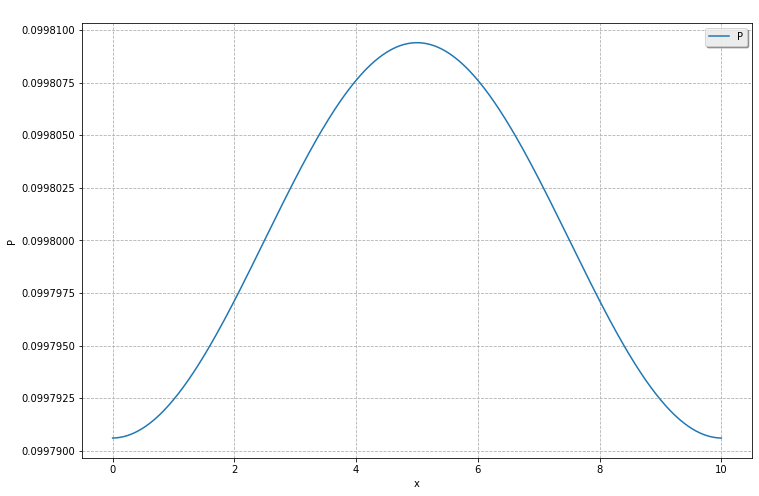

In [0]:
#Plotting Labels
plt.figure(figsize=(12,8))
plt.xlabel('x')
plt.ylabel('P')
plt.title(' ')
plt.grid(linestyle='dashed')

#Plot the Function
#plt.plot(x, f_0, label='$f_0$')
plt.plot(x, f, label='P')

#Legend Settings
legend = plt.legend(loc = 1, shadow = 'true')
frame = legend.get_frame()
frame.set_alpha(0.8)

and animation:

In [0]:
print('It took', iter, 'iterations to generate P(x,t)')
ani5

It took 250000 iterations to generate P(x,t)


#### Part B - Solve the 1D Diffusion Equation using 5-Point Stencil and RK method

Now generate the data for the 5-point stencil using the RK method to solve the 1D Diffusion equation.

In [0]:
#Solve the 1D Diffusion Equation using 5-Point Stencil and RK method

%%capture 
fig = plt.figure()
imgs6 = []

N = 200
h = 0.02 #Temporal spacing
tol = 1e-6
x, f = init_interval1(N)
M = gen_5ptmatrix(N)
iter = 0

f_0 = f.copy()
f_prev = f.copy()

count = 0
#while count != len(f):
while iter < 1e6: 
  img = plt.plot(x, f, color = 'black')
  imgs6.append(img)

  f1 = rk_step(M, h, f)
  iter += 1
  while iter % 5000 != 0:
    f = f1.copy()
    f1 = rk_step(M, h, f)
    iter += 1

  count = 0
  for a_i, b_i in zip(f1, f_prev):
    if abs(a_i - b_i) < tol:
      count += 1

  f_prev = f1.copy()
  
ani6 = animation.ArtistAnimation(fig, imgs6)
ani6.save('Animation6.mp4')
rc('animation', html='html5')

Plotting:

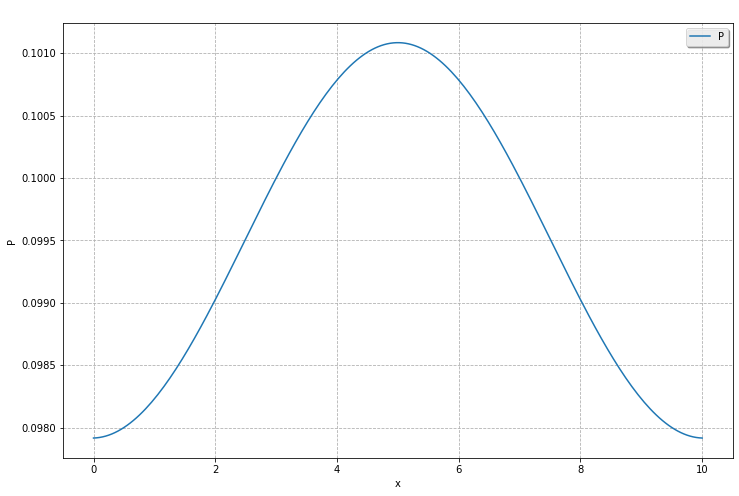

In [0]:
#Plotting Labels
plt.figure(figsize=(12,8))
plt.xlabel('x')
plt.ylabel('P')
plt.title(' ')
plt.grid(linestyle='dashed')

#Plot the Function
#plt.plot(x, f_0, label='$f_0$')
plt.plot(x, f1, label='P')

#Legend Settings
legend = plt.legend(loc = 1, shadow = 'true')
frame = legend.get_frame()
frame.set_alpha(0.8)

With animation:

In [0]:
print('It took', iter, 'iterations to generate P(x,t)')
ani6

It took 1000000 iterations to generate P(x,t)


#### Part C - Solve the Schrodinger Equation using 3-Point Stencil and RK method

Let us produce the data for the 3-point stencil using the RK method to solve the Schrodinger equation.

In [0]:
#Solve the Schrodinger Equation using 3-Point Stencil and RK method

%%capture 
fig = plt.figure()
imgs7 = []

N = 100
h = 0.01 #Temporal spacing
tol = 1e-6
x, f = init_interval2(N)
M = gen_3ptmatrix(N)
iter = 0

f_0 = f.copy()

count = 0
#while count != len(f):
while iter < 30000:
  if (iter % 500 == 0):
    img = plt.plot(x, f, color = 'black')
    imgs7.append(img)
  
  f1 = rk_step(M, h, f, complex = True)
  iter += 1 

  count = 0
  for a_i, b_i in zip(f, f1):
    if abs(a_i - b_i) < tol:
      count += 1

  f = f1.copy()

ani7 = animation.ArtistAnimation(fig, imgs7)
ani7.save('Animation7.mp4')
rc('animation', html='html5')

Plotting:

/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


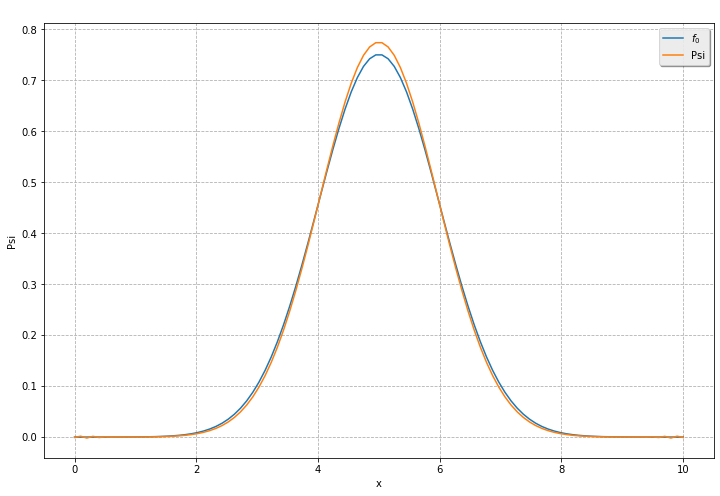

In [0]:
#Plotting Labels
plt.figure(figsize=(12,8))
plt.xlabel('x')
plt.ylabel('Psi')
plt.title(' ')
plt.grid(linestyle='dashed')

#Plot the Function
plt.plot(x, f_0, label='$f_0$')
plt.plot(x, f, label='Psi')

#Legend Settings
legend = plt.legend(loc = 1, shadow = 'true')
frame = legend.get_frame()
frame.set_alpha(0.8)

with animation:

In [0]:
print('It took', iter, 'iterations to generate Psi(x,t)')
print('The total probability of the probability distribution of the final iteration is', abs(np.trapz(f**2, x)))
ani7

It took 30000 iterations to generate Psi(x,t)
The total probability of the probability distribution of the final iteration is 1.032046434480613


#### Part D - Solve the Schrodinger Equation using 5-Point Stencil and RK method

Let us produce the data for the 5-point stencil using the RK method to solve the Schrodinger equation.

In [0]:
#Solve the Schrodinger Equation using 5-Point Stencil and RK method

%%capture 
fig = plt.figure()
imgs8 = []

N = 100
h = 0.01 #Temporal spacing
tol = 1e-6
x, f = init_interval2(N)
M = gen_5ptmatrix(N)
iter = 0

f_0 = f.copy()

count = 0
#while count != len(f):
while iter < 1500:
  if (iter % 250 == 0):
    img = plt.plot(x, f, color = 'black')
    imgs8.append(img)
  
  f1 = rk_step(M, h, f, complex = True)
  iter += 1

  count = 0
  for a_i, b_i in zip(f, f1):
    if abs(a_i - b_i) < tol:
      count += 1

  f = f1.copy()

ani8 = animation.ArtistAnimation(fig, imgs8)
ani8.save('Animation7.mp4')
rc('animation', html='html5')

Plotting:

/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


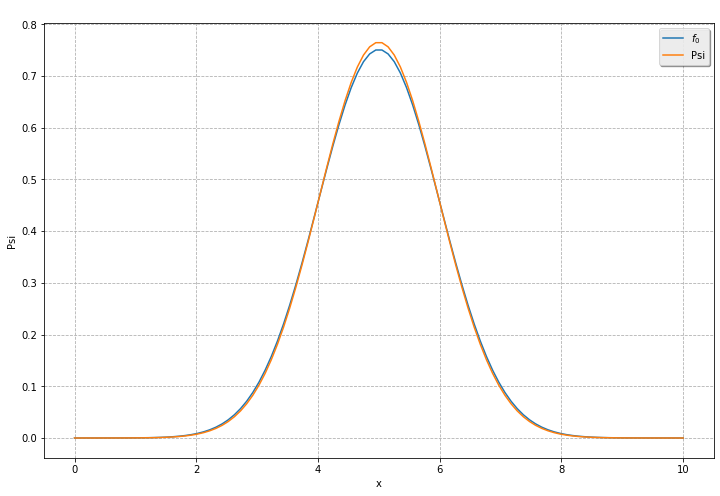

In [0]:
#Plotting Labels
plt.figure(figsize=(12,8))
plt.xlabel('x')
plt.ylabel('Psi')
plt.title(' ')
plt.grid(linestyle='dashed')

#Plot the Function
plt.plot(x, f_0, label='$f_0$')
plt.plot(x, f, label='Psi')

#Legend Settings
legend = plt.legend(loc = 1, shadow = 'true')
frame = legend.get_frame()
frame.set_alpha(0.8)

with animation:

In [0]:
print('It took', iter, 'iterations to generate Psi(x,t)')
print('The total probability of the probability distribution of the final iteration is', abs(np.trapz(f**2, x)))
ani8

It took 1500 iterations to generate Psi(x,t)
The total probability of the probability distribution of the final iteration is 1.0188871135321536


# Problem 4

Use the Fourier approach to obtain the evolution of both the diffusion and Schrodinger equations. Compare the behavior with that obtained above. 

We can calculate our final result by using the following solution:

$$
p(n,t)=\exp\left[-D\left(\frac{2\pi n}{L}\right)^2t\right]p(n,0)
$$

Where $p(n,0)$ is our intial array, and we need only multiplty the solution by the expontential term for a given time $t$ for which we wish to evaluate the function. As such, we must convert our initial passed array $p(x)$; for which we must convert to $p(n)$.


### Part A: Diffusion Equation

Now, we know that $p(x)$ is defined by the following expression:

$$
p(x)=\frac{1}{\sqrt{N}}\sum_x e^{i2\pi nx/L}p(n)
$$

Thereby, we can define $p(n)$ as follows:

$$
p(n)= \frac{1}{\sqrt{N}}\sum_x e^{-i2\pi nx/L}p(x)
$$

As such, allow us to generate a function that will do this for us:

In [0]:
def inverse_fourier(px,xvals):

  """

  This function will transfer us from to k-space

  """

  N = len(px)

  pn_list = [] 
    
  for n in range(0,100):
    val = 0
    for p,x in zip(px,xvals):
      val += np.exp((-1j*2*np.pi*n*x)/(10))*p

    pn_list.append((1/(np.sqrt(N)))*val)

  return pn_list

Creating values:

In [0]:
xvals = []

for i in np.arange(0,10,0.1):
  xvals.append(i)

In [0]:
x, start = init_interval1(100) # Initial array
pn_initial = inverse_fourier(start,xvals)
print(pn_initial)
#print(start)

[(0.9899999999991318+0j), (-0.8982778129320631-0.02822951753004247j), (0.6710218844705267+0.04221711858137994j), (-0.41267860579270454-0.039009613579674175j), (0.20894613830812211+0.026396035781179418j), (-0.08709653045480957-0.013794735230293814j), (0.029888736605086504+0.005701581438843583j), (-0.008444026920392301-0.0018874636390041263j), (0.001963908212423142+0.0005042459247176182j), (-0.0003760238956187194-0.00010924504044995045j), (5.9268569996570806e-05+1.925752575952066e-05j), (-7.690227137382395e-06-2.7686521318795725e-06j), (8.213890369822175e-07+3.252109255038172e-07j), (-7.221806356957253e-08-3.125154702783495e-08j), (5.226010373434424e-09+2.459174200488649e-09j), (-3.1174529364745735e-10-1.5884226845882978e-10j), (1.488590520052014e-11+8.184624680398535e-12j), (-9.62523527291304e-13-5.699924783967168e-13j), (-2.9728945081325433e-13-1.8745758714140848e-13j), (-2.9088727581388193e-13-1.9765975722070672e-13j), (-2.63815705331504e-13-1.9156103504985678e-13j), (-2.4305466417640

Now that we have completed this, we can now calculate the final result in k space by using the following equation:

$$
p(n,t)=\exp\left[-D\left(\frac{2\pi n}{L}\right)^2t\right]p(n,0)
$$

As such, we have:

In [0]:
def pn_t(a,h,t,pn_i):

  """


  """

  pn_final = []

  for n in range(100):
    pn_f = np.exp(-1*(a**2/(2*h))*((2*np.pi*n/10)**2)*t)*pn_i[n-1]
    pn_final.append(pn_f)

  return pn_final

In [0]:
pn_t_vals = pn_t(0.1,0.01,1000,pn_initial)
print(pn_t_vals)

[(-0.8982778129320645+0.02822951753006618j), (1.8592620093901923e-86+0j), -0j, 0j, -0j, 0j, -0j, 0j, -0j, 0j, -0j, 0j, -0j, 0j, -0j, 0j, -0j, 0j, -0j, -0j, -0j, -0j, -0j, -0j, -0j, -0j, -0j, -0j, -0j, -0j, -0j, -0j, -0j, -0j, -0j, -0j, -0j, -0j, -0j, -0j, -0j, -0j, -0j, -0j, -0j, -0j, -0j, -0j, -0j, -0j, 0j, 0j, (-0+0j), (-0+0j), (-0+0j), (-0+0j), (-0+0j), (-0+0j), (-0+0j), (-0+0j), (-0+0j), (-0+0j), (-0+0j), (-0+0j), (-0+0j), (-0+0j), (-0+0j), (-0+0j), (-0+0j), (-0+0j), (-0+0j), (-0+0j), (-0+0j), (-0+0j), (-0+0j), (-0+0j), (-0+0j), (-0+0j), (-0+0j), (-0+0j), (-0+0j), (-0+0j), (-0+0j), (-0+0j), (-0+0j), 0j, (-0+0j), 0j, (-0+0j), 0j, (-0+0j), 0j, (-0+0j), 0j, (-0+0j), 0j, (-0+0j), 0j, (-0+0j), 0j]


Now, allow us to convert our values back to $x$ space. We can do this by utilizing the following equation:

$$
p(x)=\frac{1}{\sqrt{N}}\sum_n e^{i2\pi nx/L}p(n)
$$

Which we can do with the following function:

In [0]:
def fourier(pn,xvals,nvals):

  """
  L = 10 - i.e it is the length of the lattice
  """

  px_list = [] 
  N = len(pn)

  for x in xvals:
    val = 0
    for p,n in zip(pn,nvals):
      val += np.exp((1j*2*np.pi*n*x)/(10))*p

    px_list.append(-1*(1/(np.sqrt(N)))*val)

  return px_list

Saving values for plotting:

In [0]:
nvals = []

for i in range(100):
  nvals.append(i)
#print(nvals)

In [0]:
px_t = fourier(pn_t_vals,xvals,nvals) # Just ploting the real values
px_initial_test = fourier(pn_initial,xvals,nvals)

/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


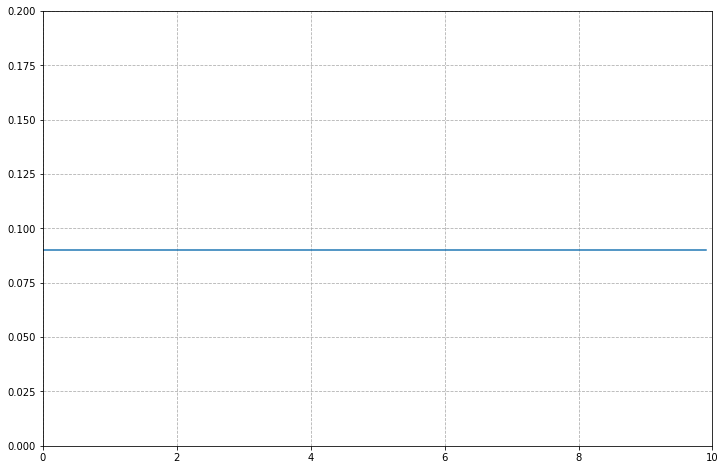

In [0]:
#Plotting Labels
plt.figure(figsize=(12,8))
#plt.xlabel('T')
#plt.ylabel('U(T)')
#plt.title('Mean Internal Energy as a function of T for Ising model')
plt.grid(linestyle='dashed')
plt.xlim(0,10)
plt.ylim(0,0.2)

#Plot the Function
#plt.plot(xvals,start,label='')
#plt.scatter(xvals,px_initial_test,label='')
#plt.plot(xvals,pn_initial,label='')
plt.plot(xvals,px_t,label='')

Awesome! We returned the result we expected!


### Part A: Schrodinger Equation

Now, allow us to perform the exact same operation, but this time, with the data from the schrodinger equation! Now, recall that our initial wavefunction amplitudes are given by the following expression:

$$
\psi(x) =\frac{1}{\sqrt{N}}\sum_n\left(\frac{2\pi n}{L}\right)^2e^{i2\pi nx/L}\psi(n)
$$

Thereby, to convert $\psi$ from $x$ space to $k$ space we may write:

$$
\psi(n) =\frac{1}{\sqrt{N}}\sum_x\left(\frac{2\pi n}{L}\right)^2e^{-i2\pi nx/L}\psi(x)
$$

We can do this with the following expression:

In [0]:
def inverse_fourier_schrod(px,xvals):

  """

  This function will transfer us from to k-space

  """

  N = len(px)

  pn_list = [] 
    
  for n in range(0,100):
    val = 0
    for p,x in zip(px,xvals):
      val += np.exp((-1j*2*np.pi*n*x)/(10))*p

    pn_list.append((1/(np.sqrt(N)))*val)

  return pn_list

Storing values for plotting:

In [0]:
xvals_s, start_sch = init_interval2(100)
pn_initial_s = inverse_fourier_schrod(start_sch,xvals)
#print(pn_initial)
#print(start)

Now, we can define the solution to the schrodinger equation in k-space with the following expression:


$$
\psi(n,t)=\exp\left[-\frac{i}{\hbar}\frac{\hbar^2}{2m}\left(\frac{2\pi n}{L}\right)^2t\right]\psi(n,0)
$$

Which again, if we set:

$$
m=1 \: and \: \hbar =1
$$

then we find that:

$$
\psi(n,t)=\exp\left[\frac{-i}{2}\left(\frac{2\pi n}{L}\right)^2t\right]\psi(n,0)
$$

Now, allow us to perform this operation with the following function:

In [0]:
def psi_n_t(pn_i,t):

  """


  """

  pn_final = []

  for n in range(100):
    pn_f = np.exp((-1j/2)*(((2*np.pi*n)/10)**2)*t)*pn_i[n-1]
    pn_final.append(pn_f)

  return pn_final

In [0]:
pn_schrod_vals = psi_n_t(pn_initial_s,500)

And moving back to $x$ space so we can visualize our answer:

In [0]:
def fourier_schrod(pn,xvals,nvals):

  """
  L = 10 - i.e it is the length of the lattice
  """

  px_list = [] 
  N = len(pn)

  for x in xvals:
    val = 0
    for p,n in zip(pn,nvals):
      val += np.exp((1j*2*np.pi*n*x)/(10))*p

    px_list.append(1*(1/(np.sqrt(N)))*val)
  return px_list

And generating values for plotting:

In [0]:
px_schrod = fourier_schrod(pn_schrod_vals,xvals,nvals)
px_schrod_test = fourier_schrod(pn_initial_s,xvals,nvals)
print(px_schrod_test)

[(2.799184389057352e-06+3.0704605524789486e-15j), (4.6148394116318775e-06+6.669664820435628e-15j), (7.5309637038945e-06+6.336597913048081e-15j), (1.216503580343531e-05+5.77871084317394e-15j), (1.9451141992354873e-05+8.903988657493756e-15j), (3.078546322847764e-05+7.183142969324763e-15j), (4.822976626421838e-05+4.307665335545608e-15j), (7.479171594722002e-05+7.038813976123493e-15j), (0.00011480497632703202+6.994405055138487e-16j), (0.00017443627548743292+2.7311486405778852e-15j), (0.00026235042542011033+1.7097434579227411e-15j), (0.00039056706326325854+1.1324274851176598e-15j), (0.0005755437411055553+8.43769498715119e-16j), (0.0008395178419801975+4.7517545453956705e-15j), (0.0012121333527708056+1.9317880628477726e-15j), (0.0017323663848128558+2.4202861936828413e-15j), (0.002450744126520299+3.819167204710538e-15j), (0.00343182448729068+1.7763568394002506e-16j), (0.004756867371916185+3.6637359812630166e-15j), (0.00652658341107556+1.509903313490213e-15j), (0.008863793270098936+2.2204460492

And plotting yields:

/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


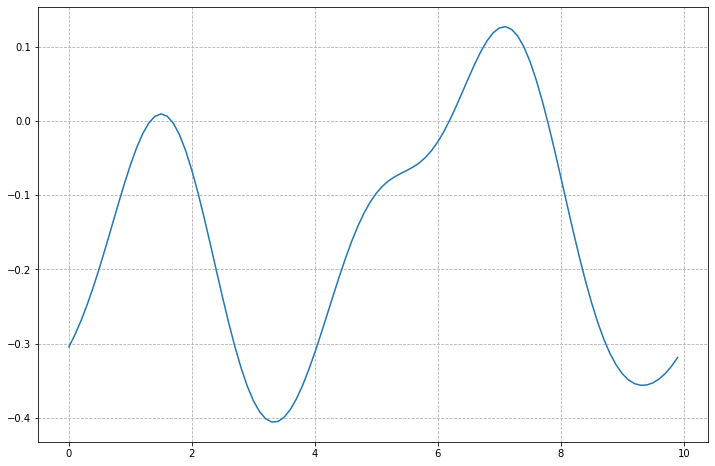

In [0]:
#Plotting Labels
plt.figure(figsize=(12,8))
#plt.xlabel('T')
#plt.ylabel('U(T)')
#plt.title('Mean Internal Energy as a function of T for Ising model')
plt.grid(linestyle='dashed')
#plt.xlim(0,10)
#plt.ylim(0,0.2)

#Plot the Function

#plt.plot(xvals,pn_initial_s,label='')
#plt.scatter(xvals,px_schrod_test,label='')
#plt.plot(xvals,start_sch ,label='')
plt.plot(xvals,px_schrod)


All wonky because it is not $2\pi$ periodic.

Unforunately, we were unable to approximate the final solution to the schrodinger equation. There is something wrong in our code, that we unfortunately do not have time to fix! I believe that the issue has something to do with the prefactor but I cannot deduce what!


2 questions (one magnetic field and one differential equations). Something to do with the ising model - may a spin-1 system. For question 2 he will do a partial differential equation (i.e time dependant). No Fourier stuff - but maybe a diffusion equation with an extra potential.